In [74]:
# importing all the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import re
plt.style.use('ggplot')

Reading news datas into dataframes

In [75]:
false_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

Checking if there are any null values

In [76]:
false_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [77]:
true_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

Checking for unique values to have a similar distribution

In [78]:
false_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [79]:
true_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

Dropping the columns where we can't see strong correlation or might have a bad effect on the accuracy

In [80]:
false_df.drop(['date', 'subject'], axis=1, inplace=True)
true_df.drop(['date', 'subject'], axis=1, inplace=True)

We will add a column for class with values of false news as 0 and true news as 1

In [81]:
false_df['class'] = 0
true_df['class'] = 1

Making a graph to compare news

Text(0, 0.5, 'Proportion of News Articles')

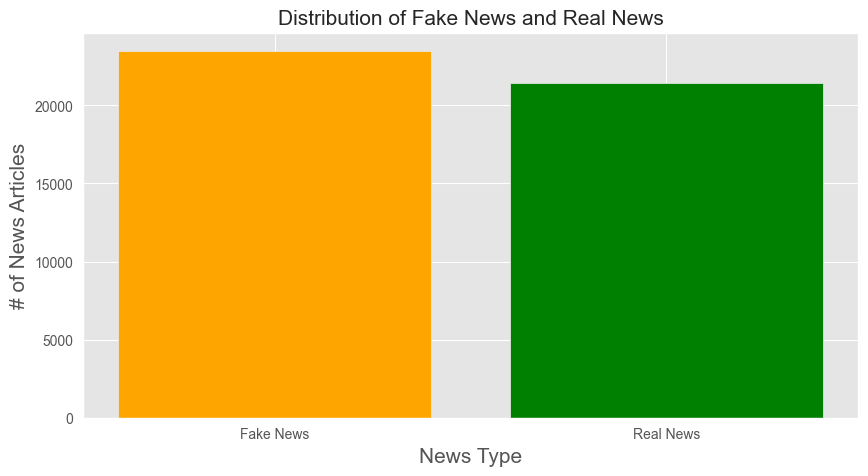

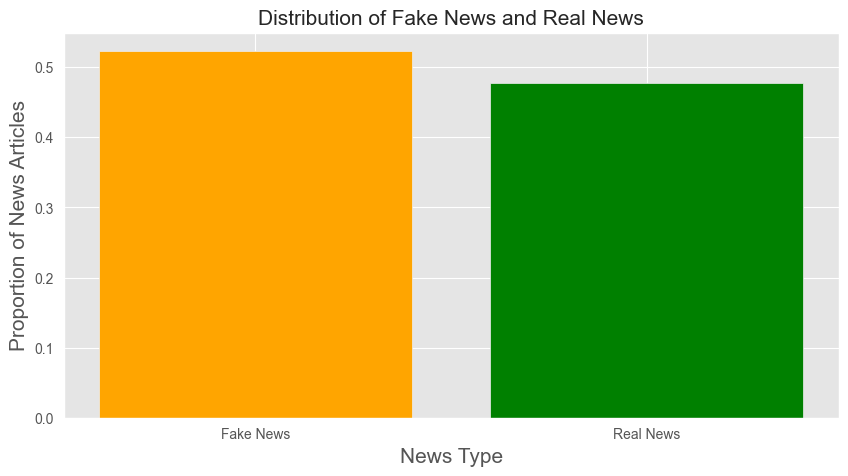

In [82]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(false_df), color='orange')
plt.bar('Real News', len(true_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

total_len = len(false_df) + len(true_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(false_df) / total_len, color='orange')
plt.bar('Real News', len(true_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [83]:
print('Difference between fake news and real news:', len(false_df)-len(true_df))

Difference between fake news and real news: 2064


Combining two dataframes into one as news

In [84]:
news_df = pd.concat([false_df, true_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [85]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

Split the dataframe into test and train

In [86]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

Normalizing our datasets such as lower case, getting rid of urls or any kind of not wanted characters

In [87]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

Converting the text to vectors

In [88]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Applying padding to have the same length for each article

In [89]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Building the model

In [90]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

Using early stop function to stop when validation loss no longer improves later training and starting the model

In [91]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 218s 199ms/step - loss: 0.2909 - accuracy: 0.8542 - val_loss: 0.1782 - val_accuracy: 0.9184
Epoch 2/10
1078/1078 [==============================] - 213s 197ms/step - loss: 0.0980 - accuracy: 0.9696 - val_loss: 0.0703 - val_accuracy: 0.9780
Epoch 3/10
1078/1078 [==============================] - 217s 201ms/step - loss: 0.0464 - accuracy: 0.9868 - val_loss: 0.0473 - val_accuracy: 0.9841
Epoch 4/10
1078/1078 [==============================] - 212s 197ms/step - loss: 0.0329 - accuracy: 0.9910 - val_loss: 0.0516 - val_accuracy: 0.9844
Epoch 5/10
1078/1078 [==============================] - 211s 196ms/step - loss: 0.0209 - accuracy: 0.9945 - val_loss: 0.0593 - val_accuracy: 0.9855


Saving history as a dictionary. Visualizing loss and accuracy datas according to epochs.

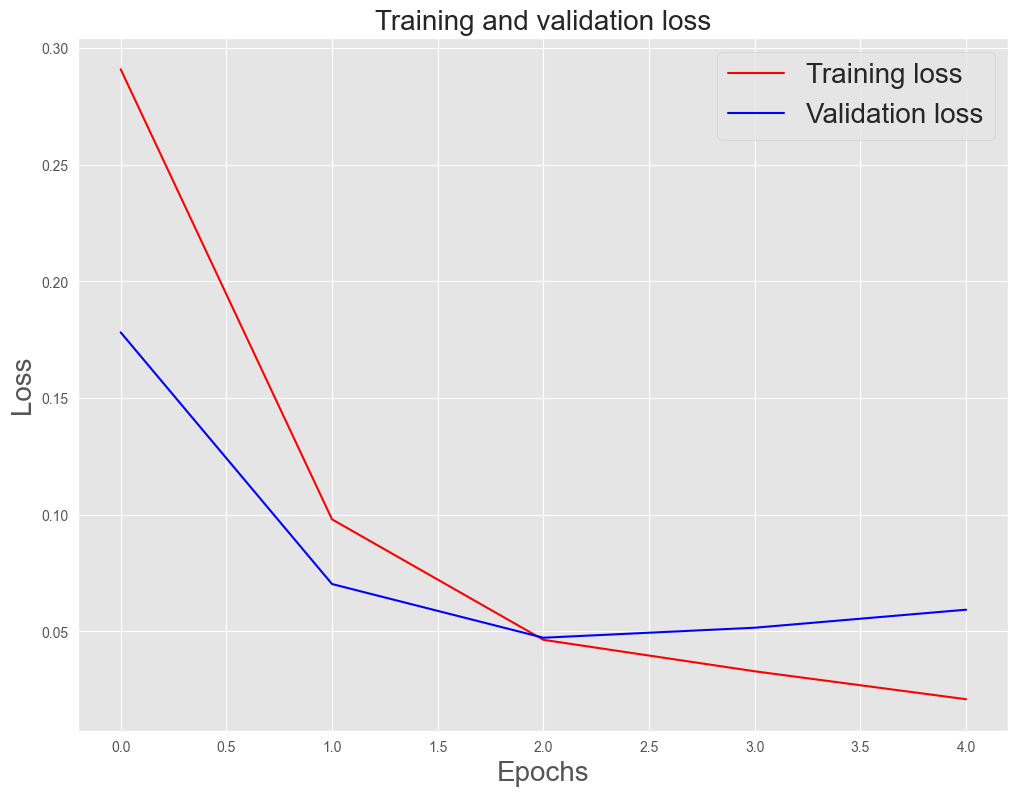

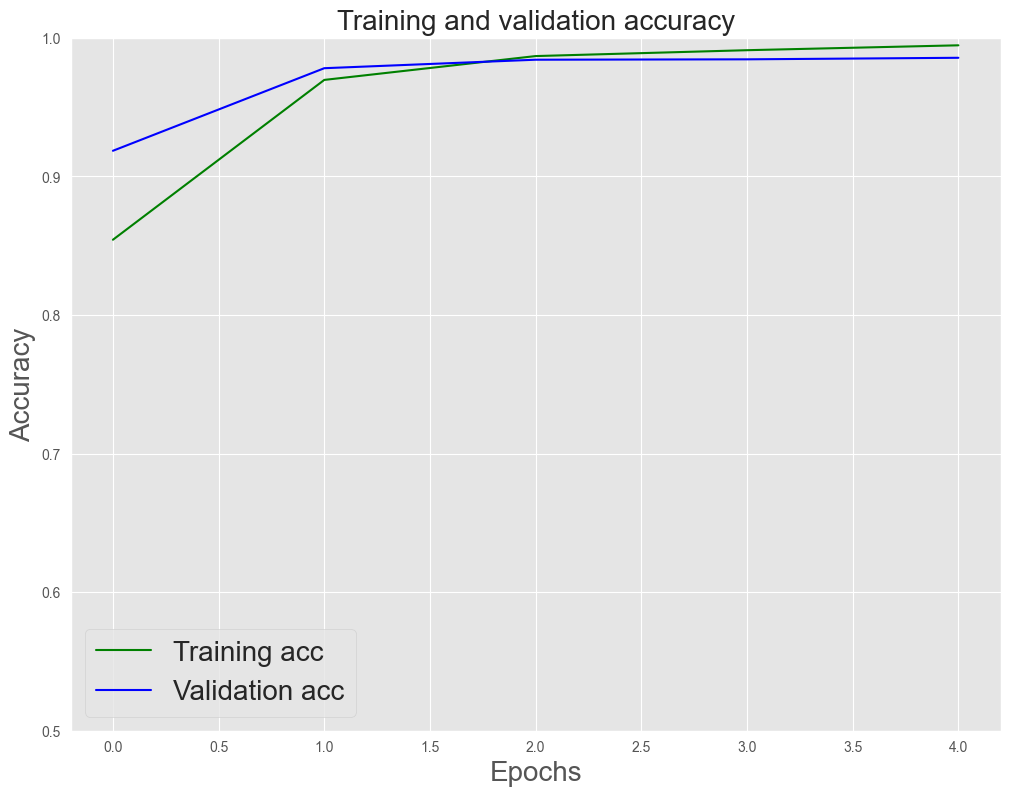

In [92]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluating the testing set

In [93]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 13s 47ms/step - loss: 0.0474 - accuracy: 0.9843


[0.047357577830553055, 0.9842984676361084]

With testing making predictions and printing the accuracy, precision and recall values.

In [94]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

281/281 [==============================] - 13s 45ms/step
Accuracy on testing set: 0.9842984409799554
Precision on testing set: 0.9812413154238073
Recall on testing set: 0.9860367698394229


Confusion matrix and visualizing it

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

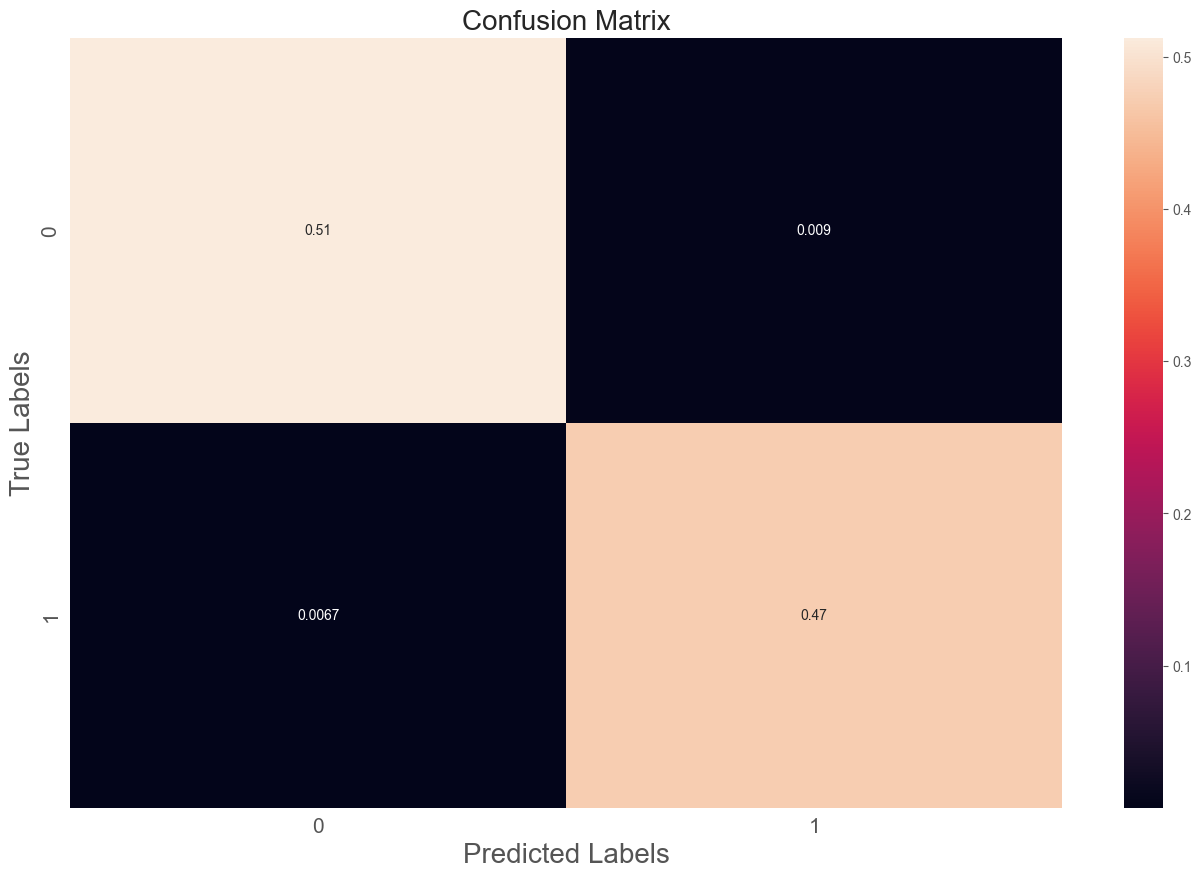

In [95]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

Saving the weights to use later

In [96]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 128)


In [97]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

Writing the vectors and metadata to files, so we can see what our network learned.

In [99]:
with open('fakenews_vecs.tsv', 'w', encoding='utf-8') as out_vec_file:
    for num, word in enumerate(word_index):
      vec = weights[num+1]
      out_vec_file.write('\t'.join([str(x) for x in vec]) + "\n")

with open('fakenews_meta.tsv', 'w', encoding='utf-8') as out_meta_file:
    for num, word in enumerate(word_index):
        vec = weights[num+1]
        out_meta_file.write(word + "\n")